<a href="https://colab.research.google.com/github/VTPrince/earthquakeprediction/blob/main/Untitled27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pycaret

In [ ]:
pip install geoplot

In [11]:
import pycaret
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import folium
from geopy.geocoders import Nominatim
from geopy import distance
import imageio
from tqdm import tqdm_notebook
from folium.plugins import MarkerCluster
import geoplot as gplt
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
import geoplot.crs as gcrs
from sklearn.metrics import accuracy_score
import imageio
import mapclassify as mc
import scipy
from itertools import product
import seaborn as sns

In [12]:
import geopy

In [13]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [14]:
data=pd.read_csv('/content/California_Fire_Incidents.csv')

In [15]:
city_data=data.drop_duplicates(subset=['Counties'])

In [16]:
LAT = []
LONG = []
for city in city_data.Counties.tolist():
    locator = Nominatim()
    location = locator.geocode(city)
    LAT.append(location.latitude)
    LONG.append(location.longitude)

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [17]:
city_data.Latitude = LAT
city_data.Longitude = LONG
city_data = city_data.drop(city_data[city_data.Counties=='Santa Cruz'].index)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
world_map= folium.Map()
geolocator = Nominatim(user_agent="Piero")
marker_cluster = MarkerCluster().add_to(world_map)

for i in range(len(city_data)):
        lat = city_data.iloc[i]['Latitude']
        long = city_data.iloc[i]['Longitude']
        radius=5
        folium.CircleMarker(location = [lat, long], radius=radius,fill =True, color='darkred',fill_color='darkred').add_to(marker_cluster)

In [ ]:
world_map

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


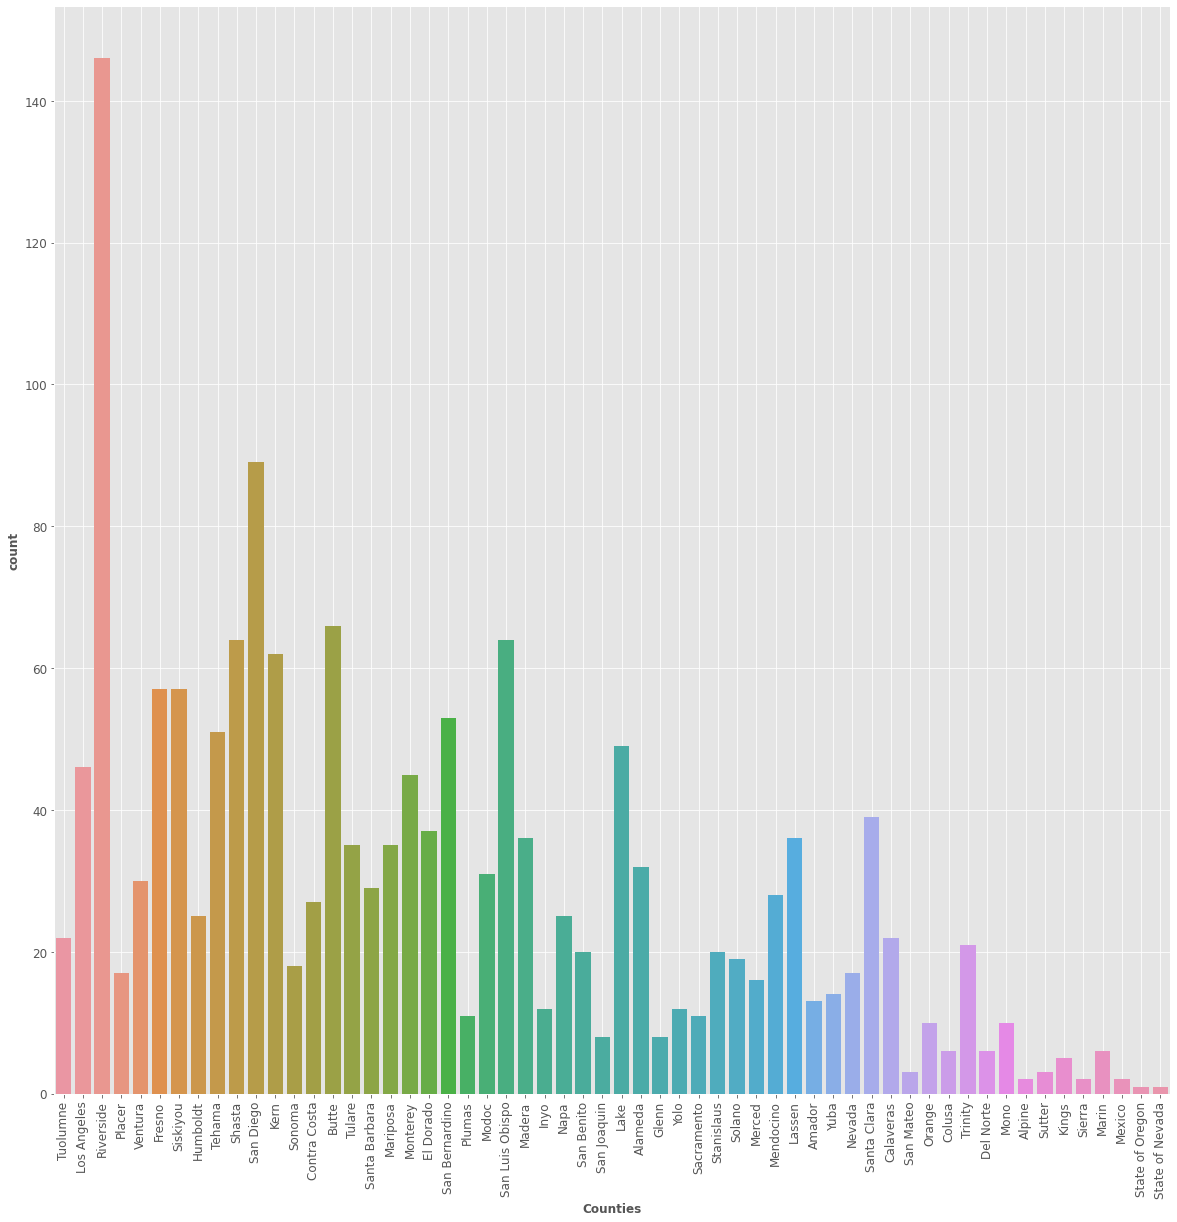

In [19]:
data = data[data['Counties']!='Santa Cruz']
plt.figure(figsize=(20,20))
sns.countplot(data.Counties)
plt.xticks(rotation=90)
plt.grid(True)

In [20]:
lat=city_data.Latitude.to_list()
lon=city_data.Longitude.to_list()
dist=[]
for i in range(len(lat)):
  lat_i=(lat[i],lon[i])
  I_dist=[]
  for j in range(len(lat)):
    lat_j=(lat[j],lon[j])
    I_dist.append(distance.vincenty(lat_i,lat_j).km)
  dist.append(I_dist)
dist = np.array(dist)

In [ ]:
dist_data = pd.DataFrame(dist,columns=city_data.Counties)
dist_data.index = city_data.Counties
plt.figure(figsize=(20,20))
sns.heatmap(dist_data)

In [22]:
from datetime import datetime

In [29]:
la = data[data['Counties']=='Los Angeles'].sort_values(by='Started').reset_index().drop(['index','AcresBurned'],axis=1)
data = data.sort_values(by='Started').reset_index().drop(['index'],axis=1)
data = data.drop([0,1]).reset_index().drop('index',axis=1)
non_la = data[data['Counties']!='Los Angeles'].reset_index().drop('index',axis=1)
non_la['AcresBurned'] = non_la['AcresBurned'].fillna(non_la['AcresBurned'].mean())
one_three = []
three_seven = []
seven_ten = []
no=[]
""" dtome=[]
dyome=[]
num=0
for x in range(len(non_la['Started'])):
  dto = datetime.strptime(non_la['Started'].loc[x], '%Y-%m-%d').date()
  dtome.append(dto)
for y in range(len(la['Started'])):
  dto = datetime.strptime(la['Started'].loc[y], '%Y-%m-%d').date()
  dyome.append(dto)
for i in range(len(la)):
  diff = dtome.subtract(dyome[i])
  diff = diff.reset_index().drop('index',axis=1)
  s = diff.Started.tolist()
  for d in range(len(s)):
    day = s[d].days
    if (day<=-1) == True and (day>=-3)==True:
      one_three.append(d)
    if (day<-3) == True and  (day>=-7) == True:
      three_seven.append(d)
    if (day<-7) == True and  (day>=-10)==True:
      seven_ten.append(d)
    if (day<-10)==True:
      no.append(d)"""
type(la)

pandas.core.frame.DataFrame

In [30]:
x=[]
x=non_la['Started']
y=pd.DataFrame(x)
y.head()
modDfObj=[]
for u in range(len(y)):
  modDfObj.append(y.apply(lambda y:datetime.strptime(y[u], '%Y-%m-%d').date() ))
modDfObj[1]

Started    2013-04-09
dtype: object

In [31]:
x=[]
x=non_la['Started']
y=pd.DataFrame(x)
y.head()
modDfObj=[]
for u in range(len(y)):
  modDfObj.append(y.apply(lambda y:datetime.strptime(y[u], '%Y-%m-%d').date() ))
modDfObj[1]

Started    2013-04-09
dtype: object

In [32]:
w=[]
w=la['Started']
e=pd.DataFrame(w)
mod=[]
for u in range(len(e)):
  mod.append(y.apply(lambda e:datetime.strptime(e[u], '%Y-%m-%d').date() ))
mod[1]

Started    2013-04-09
dtype: object

In [33]:
mody=pd.DataFrame(mod)
modDfObjy=pd.DataFrame(modDfObj)

In [34]:
for i in range(len(la)):
  diff = modDfObjy['Started']-mody['Started'].loc[i]
  diff = diff.reset_index().drop('index',axis=1)
  s = diff.Started.tolist()
  for d in range(len(s)):
    day = s[d].days
    if (day<=-1) == True and (day>=-3)==True:
      one_three.append(d)
    if (day<-3) == True and  (day>=-7) == True:
      three_seven.append(d)
    if (day<-7) == True and  (day>=-10)==True:
      seven_ten.append(d)
    if (day<-10)==True:
      no.append(d)

In [36]:
one_three_data = non_la.loc[one_three][0:180]
one_three_data['Class'] = ['1-3 Days']*len(one_three_data)
three_seven_data = non_la.loc[three_seven][0:180]
three_seven_data['Class'] = ['3-7 Days']*len(three_seven_data) 
seven_ten_data = non_la.loc[seven_ten][0:180]
seven_ten_data['Class'] = ['7-10 Days']*len(seven_ten_data)
no_fire_data = non_la.loc[no][0:180]
no_fire_data['Class'] = ['No Wildfire (+10 Days)']*len(no_fire_data)
no_fire_data = no_fire_data.sample(frac=1)

In [37]:
wildfire_data = one_three_data.append(three_seven_data).append(seven_ten_data).append(no_fire_data)
wildfire_data = wildfire_data.reset_index().drop('index',axis=1)
distances_la = []
for i in range(len(wildfire_data)):
  distances_la.append(dist_data[wildfire_data['Counties'].loc[i]].loc['Los Angeles'])
wildfire_data['Distance'] = distances_la
wildfire_data['Class'] = LabelEncoder().fit_transform(wildfire_data.Class)
years = []
months = []
days = []
wildfire_data.head()

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Featured,Final,FuelType,Helicopters,Injuries,Latitude,Location,Longitude,MajorIncident,Name,PercentContained,PersonnelInvolved,Public,SearchDescription,SearchKeywords,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,Class,Distance
0,274.0,False,CAL FIRE Madera-Mariposa-Merced Unit,NaN,2013,True,/incidents/2013/4/30/gold-fire/,NaN,NaN,Madera,20,NaN,NaN,NaN,2013-05-01,False,True,NaN,NaN,NaN,37.116295,Between Road 210 and Road 200 near Fine Gold C...,-119.635004,False,Gold Fire,100.0,NaN,True,The Gold Fire burned in April 2013 and May 201...,"Gold Fire, April 2013, May 2013, Fine Gold Cre...",2013-04-30,NaN,NaN,NaN,NaN,357ffc13-bef9-48eb-810f-c5de851972eb,2013-05-01,0,362.336140
1,75.0,False,CAL FIRE Sonoma-Lake-Napa Unit,NaN,2013,True,/incidents/2013/4/30/silverado-fire/,NaN,NaN,Napa,28,NaN,NaN,NaN,2013-05-01,False,True,NaN,NaN,NaN,38.441792,"7300 block of Silverado Trail, north of Napa",-122.350844,False,Silverado Fire,100.0,NaN,True,The Silverado Fire burned in April 2013 and Ma...,"Silverdo Fire, April 2013, May 2013, Napa, Nap...",2013-04-30,NaN,NaN,NaN,NaN,d8d1c943-7b5d-4885-9043-f41075d6eded,2013-05-01,0,12735.229534
2,274.0,False,CAL FIRE Madera-Mariposa-Merced Unit,NaN,2013,True,/incidents/2013/4/30/gold-fire/,NaN,NaN,Madera,20,NaN,NaN,NaN,2013-05-01,False,True,NaN,NaN,NaN,37.116295,Between Road 210 and Road 200 near Fine Gold C...,-119.635004,False,Gold Fire,100.0,NaN,True,The Gold Fire burned in April 2013 and May 201...,"Gold Fire, April 2013, May 2013, Fine Gold Cre...",2013-04-30,NaN,NaN,NaN,NaN,357ffc13-bef9-48eb-810f-c5de851972eb,2013-05-01,0,362.336140
3,75.0,False,CAL FIRE Sonoma-Lake-Napa Unit,NaN,2013,True,/incidents/2013/4/30/silverado-fire/,NaN,NaN,Napa,28,NaN,NaN,NaN,2013-05-01,False,True,NaN,NaN,NaN,38.441792,"7300 block of Silverado Trail, north of Napa",-122.350844,False,Silverado Fire,100.0,NaN,True,The Silverado Fire burned in April 2013 and Ma...,"Silverdo Fire, April 2013, May 2013, Napa, Nap...",2013-04-30,NaN,NaN,NaN,NaN,d8d1c943-7b5d-4885-9043-f41075d6eded,2013-05-01,0,12735.229534
4,274.0,False,CAL FIRE Madera-Mariposa-Merced Unit,NaN,2013,True,/incidents/2013/4/30/gold-fire/,NaN,NaN,Madera,20,NaN,NaN,NaN,2013-05-01,False,True,NaN,NaN,NaN,37.116295,Between Road 210 and Road 200 near Fine Gold C...,-119.635004,False,Gold Fire,100.0,NaN,True,The Gold Fire burned in April 2013 and May 201...,"Gold Fire, April 2013, May 2013, Fine Gold Cre...",2013-04-30,NaN,NaN,NaN,NaN,357ffc13-bef9-48eb-810f-c5de851972eb,2013-05-01,0,362.336140


In [38]:
wildfire_data.Started[1].split("-", 2)[2]

'30'

In [39]:
for i in range(len(wildfire_data)):
  years.append(wildfire_data.Started[i].split("-", 1)[0][-4:])
  months.append(wildfire_data.Started[i].split("-", 2)[1])
  days.append(wildfire_data.Started[i].split("-", 2)[2])
wildfire_data['Year'] = years
wildfire_data['Month'] = months
wildfire_data['Days'] = days
wildfire_data = wildfire_data.sample(frac=1)
wildfire_data

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Featured,Final,FuelType,Helicopters,Injuries,Latitude,Location,Longitude,MajorIncident,Name,PercentContained,PersonnelInvolved,Public,SearchDescription,SearchKeywords,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,Class,Distance,Year,Month,Days
244,40.0,False,CAL FIRE Riverside Unit,2.0,2013,True,/incidents/2013/5/16/54-fire/,Go to Administrative Unit Link for full descri...,NaN,Riverside,33,NaN,1.0,19.0,2013-05-17,False,True,NaN,NaN,NaN,33.655638,"Avenue 54 and Tyler Street, near the community...",-116.161201,True,54 Fire,100.0,65.0,True,The 54 Fire burned in May 2013 off Avenue 54 a...,"54 Fire, May 2013, Tyler Street, Riverside Cou...",2013-05-16,NaN,NaN,NaN,NaN,e215290f-d0b4-48fd-be32-f599959347b1,2013-05-17,2,77.835349,2013,05,16
175,1271.0,False,CAL FIRE San Diego Unit,27.0,2013,True,/incidents/2013/5/26/general-fire/,The fire is burning East towards the desert an...,NaN,San Diego,37,54.0,27.0,42.0,2013-05-31,False,True,NaN,27.0,6.0,33.044580,"Banner Grade area, south of Hwy 78 & east of H...",-116.520900,True,General Fire,100.0,1217.0,True,"The General Fire burned in May 2013, in the Ba...","General Fire, May 2013, San Diego County, Bann...",2013-05-26,NaN,NaN,NaN,NaN,07a5397c-a665-4f84-9a82-5f689cb2c8f3,2013-05-31,1,179.058927,2013,05,26
272,303.0,False,CAL FIRE Tuolumne-Calaveras Unit,NaN,2013,True,/incidents/2013/5/30/shelton-fire/,NaN,NaN,San Joaquin,39,NaN,NaN,NaN,2013-05-30,False,True,NaN,NaN,NaN,38.049930,off North Shelton Rd in the Linden Peters area,-120.903250,False,Shelton Fire,100.0,NaN,True,The Shelton Fire burned in May 2013 off North ...,"Shelton Fire, May 2013, North Shelton Road, Li...",2013-05-30,NaN,NaN,NaN,NaN,0b51d59b-457d-4a62-b066-55c2b8d400e2,2013-05-30,2,510.376260,2013,05,30
90,42.0,False,CAL FIRE/Riverside County Fire,NaN,2013,True,/incidents/2013/6/8/viper-fire/,NaN,NaN,Riverside,33,NaN,NaN,NaN,2013-06-08,False,True,NaN,NaN,NaN,33.969360,"off San Timoteo Canyon Rd and Viper Rd, north ...",-117.126500,False,Viper Fire,100.0,NaN,True,The Viper Fire burned in June 2013 off San Tim...,"Viper Fire, June 2013, San Timoteo Canyon Road...",2013-06-08,NaN,NaN,NaN,NaN,e9505435-e861-4f33-9069-b0040fb2a135,2013-06-08,0,77.835349,2013,06,08
428,274.0,False,CAL FIRE Madera-Mariposa-Merced Unit,NaN,2013,True,/incidents/2013/4/30/gold-fire/,NaN,NaN,Madera,20,NaN,NaN,NaN,2013-05-01,False,True,NaN,NaN,NaN,37.116295,Between Road 210 and Road 200 near Fine Gold C...,-119.635004,False,Gold Fire,100.0,NaN,True,The Gold Fire burned in April 2013 and May 201...,"Gold Fire, April 2013, May 2013, Fine Gold Cre...",2013-04-30,NaN,NaN,NaN,NaN,357ffc13-bef9-48eb-810f-c5de851972eb,2013-05-01,3,362.336140,2013,04,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,4346.0,False,CAL FIRE / USFS Los Padres National Forest,NaN,2013,True,/incidents/2013/5/15/grand-fire/,<p>Little to no fire behavior has been observe...,NaN,Ventura,"15,56",29.0,1.0,34.0,2013-05-21,False,True,NaN,1.0,4.0,34.786100,"South of Frazier Mountain Park Rd, South of Fr...",-118.941100,True,Grand Fire,100.0,847.0,True,"The Grand Fire burned in May 2013, South of Fr...","Grand Fire, May 2013, Frazier Mountain Park, U...",2013-05-15,NaN,NaN,NaN,NaN,e0d038e9-0926-4c05-8317-ec7075a04b12,2013-05-21,1,88.375892,2013,05,15
422,6965.0,False,CAL FIRE Butte Unit,NaN,2013,True,/incidents/2013/5/1/panther-fire/,Firefighters continue to mop up within the fir...,NaN,Tehama,52,53.0,22.0,131.0,2013-05-09,False,True,NaN,6.0,6.0,40.190062,"140K3 Line, 8 miles northwest of Butte Meadows",-121.595555,True,Panther Fire,100.0,1811.0,True,"The Panther Fire burned in May 2013, off the 1...","Panther Fire, May 2013, Butte M

In [40]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [41]:
#X = wildfire_data[['Distance','Year','Month','Days','AcresBurned']]
X = wildfire_data[['Distance','Days','AcresBurned']]
Y = wildfire_data.Class
#data_classification = wildfire_data[['Distance','Year','Month','Days','AcresBurned','Class']]
data_classification = wildfire_data[['Distance','Days','AcresBurned','Class']]
#data_classification['Year'] = data_classification['Year'].astype(float)
#data_classification['Month'] = data_classification['Month'].astype(float)
data_classification['Days'] = data_classification['Days'].astype(float)
data_classification = data_classification.dropna()
data_classification 

,Distance,Days,AcresBurned,Class
244,77.835349,16.0,40.0,2
175,179.058927,26.0,1271.0,1
272,510.376260,30.0,303.0,2
90,77.835349,8.0,42.0,0
428,362.336140,30.0,274.0,3
47,242.876872,20.0,35.0,0
277,242.876872,1.0,500.0,2
357,716.553703,1.0,217.0,3
80,242.876872,1.0,500.0,0
184,140.566469,28.0,170.0,1


In [42]:
s = setup(data_classification, target = 'Class',imputation_type='iterative',train_size=0.90)

,Description,Value
0,session_id,8112
1,Target,Class
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(472, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [43]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5874,0.7990,0.5192,0.5748,0.5685,0.4255,0.4327,0.464
lightgbm,Light Gradient Boosting Machine,0.5733,0.8048,0.5055,0.5630,0.5549,0.4058,0.4127,0.104
gbc,Gradient Boosting Classifier,0.5662,0.8023,0.4931,0.5513,0.5473,0.3949,0.4007,0.309
dt,Decision Tree Classifier,0.5637,0.7971,0.4872,0.5482,0.5457,0.3892,0.3944,0.014
et,Extra Trees Classifier,0.5637,0.7971,0.4872,0.5482,0.5457,0.3892,0.3944,0.456
knn,K Neighbors Classifier,0.5589,0.7818,0.4738,0.5225,0.5327,0.3801,0.3855,0.117
ada,Ada Boost Classifier,0.4032,0.7264,0.3562,0.4572,0.4133,0.1846,0.1905,0.095
dummy,Dummy Classifier,0.3655,0.5000,0.2500,0.1337,0.1957,0.0000,0.0000,0.013
lr,Logistic Regression,0.3232,0.5906,0.2393,0.2255,0.2423,-0.0106,-0.0075,0.400
svm,SVM - Linear Kernel,0.3113,0.0000,0.2444,0.2072,0.2206,-0.0021,0.0122,0.062


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=8112, verbose=0,
                       warm_start=False)

In [46]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6512,0.8461,0.5949,0.6737,0.6299,0.5099,0.5279
1,0.6279,0.7858,0.5823,0.5755,0.5837,0.4839,0.5000
2,0.5116,0.7633,0.4338,0.4833,0.4940,0.3200,0.3220
3,0.5116,0.7938,0.3965,0.4689,0.4866,0.3164,0.3187
4,0.6905,0.8343,0.6458,0.6698,0.6670,0.5667,0.5754
5,0.7143,0.8457,0.6528,0.6986,0.6924,0.5971,0.6047
6,0.5476,0.7796,0.4625,0.5119,0.5190,0.3575,0.3634
7,0.4762,0.7365,0.4431,0.4847,0.4786,0.2837,0.2844
8,0.5238,0.8025,0.4236,0.5603,0.5283,0.3503,0.3567
9,0.6190,0.8022,0.5573,0.6215,0.6058,0.4692,0.4735


In [45]:
rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6047,0.8479,0.5234,0.5986,0.5720,0.4294,0.4506
1,0.5814,0.8028,0.5108,0.5271,0.5387,0.4158,0.4271
2,0.5116,0.7829,0.4338,0.4833,0.4940,0.3200,0.3220
3,0.5116,0.7978,0.3965,0.4689,0.4866,0.3164,0.3187
4,0.6667,0.8311,0.5938,0.6425,0.6483,0.5296,0.5340
5,0.5952,0.8359,0.5542,0.6016,0.5896,0.4333,0.4355
6,0.5476,0.7791,0.4625,0.5074,0.5189,0.3590,0.3643
7,0.4524,0.7545,0.4014,0.4685,0.4595,0.2441,0.2447
8,0.5952,0.8166,0.5069,0.6490,0.5997,0.4465,0.4550
9,0.5952,0.8209,0.5216,0.5853,0.5714,0.4342,0.4404


In [47]:
model = finalize_model(rf)

In [48]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=8112, verbose=0,
                       warm_start=False)

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, train_size=0.9)

In [51]:
for col in X_test.columns:
    print(col)

Distance
Days
AcresBurned


In [121]:
type(X_test)

pandas.core.frame.DataFrame

In [114]:
y_test

71     0
210    1
422    3
534    3
137    1
507    3
254    1
303    2
418    3
329    2
212    1
351    2
337    2
405    3
85     0
103    0
45     0
2      0
297    2
56     0
478    3
503    3
326    2
535    3
190    1
502    3
19     0
325    2
91     0
537    3
428    3
83     0
258    1
92     0
437    3
94     0
327    2
424    3
37     0
182    1
207    1
238    1
519    3
6      0
377    3
445    3
89     0
75     0
383    3
62     0
453    3
511    3
16     0
300    2
184    1
Name: Class, dtype: int64

In [52]:
results = pd.DataFrame({'Predict':model.predict(X_test),'Target':y_test})
results.head()

,Predict,Target
125,1,1
303,3,3
325,3,3
209,1,1
143,1,1


In [53]:
values=[100,20,50]
features = [float(i) for i in values]
# Convert features to array
array_features = [np.array(features)]
# Predict features
prediction = model.predict(array_features)
print(prediction)

[1]


In [54]:
results.Predict.unique()

array([1, 3, 0, 2])

In [55]:
results.Predict.value_counts()

3    26
1    15
0     5
2     2
Name: Predict, dtype: int64

Text(0.5, 28.5, 'Target')

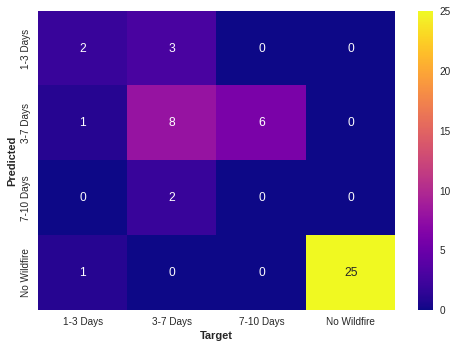

In [56]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(results['Predict'],results['Target']),annot=True,xticklabels=['1-3 Days','3-7 Days','7-10 Days','No Wildfire']
            ,yticklabels=['1-3 Days','3-7 Days','7-10 Days','No Wildfire'],cmap='plasma')
plt.ylabel('Predicted')
plt.xlabel('Target')

In [57]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [110]:
pip install joblib

In [160]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(model, 'filename.pkl')

['filename.pkl']

In [167]:
pip install pyreadstat

     |████████████████████████████████| 2.4 MB 5.2 MB/s 
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.


In [2]:
import pickle
model = pickle.load(open('/content/finalized_model.sav', 'rb'))

In [4]:
import sklearn
sklearn.__version_

AttributeError: ignored